In [1]:
import os
import json
import shutil
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from transformers import GPT2Tokenizer, GPT2LMHeadModel, BertTokenizer


In [2]:
data = pd.read_csv("dataset/CleanedBaseline/Convabuse.csv")
model_dir ='models/Baseline/LargeCNN/Convabuse/'

# data = pd.read_csv("dataset/CleanedBaseline/UCB.csv")
# model_dir ='models/Baseline/LargeCNN/UCB/'

# data = pd.read_csv("dataset/CleanedBaseline/Kaggle.csv")
# model_dir ='models/Baseline/LargeCNN/Kaggle/'



In [3]:

# Custom Dataset class
class ToxicityDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=77):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.float)
        }


In [4]:
# Load and prepare data
texts = data["sentence"].tolist()

# Debug: Print first few raw labels
print("First 5 raw labels:", data["label"].head().tolist())

# Convert labels to numeric (1 for Toxic, 0 for Non Toxic)
labels = data["label"].apply(lambda x: 1 if str(x).strip() == "toxic" else 0).tolist()

# Verify conversion
print("First 5 converted labels:", labels[:5])

# Balanced train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)


# First split: train (70%) vs temp (30%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, stratify=labels, random_state=42
)

# Second split: temp into validation (20%) and test (10%)
# Note: 20% of total is 20/30 = 2/3 of the temp, and 10% is 1/3
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=1/3, stratify=temp_labels, random_state=42
)

print(f"Train set: {len(train_texts)} samples, Toxic: {sum(train_labels)}, Non-toxic: {len(train_labels) - sum(train_labels)}")
print(f"Validation set: {len(val_texts)} samples, Toxic: {sum(val_labels)}, Non-toxic: {len(val_labels) - sum(val_labels)}")
print(f"Test set: {len(test_texts)} samples, Toxic: {sum(test_labels)}, Non-toxic: {len(test_labels) - sum(test_labels)}")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = ToxicityDataset(train_texts, train_labels, tokenizer)
val_dataset = ToxicityDataset(val_texts, val_labels, tokenizer)
test_dataset = ToxicityDataset(test_texts, test_labels, tokenizer)

# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


First 5 raw labels: ['toxic', 'non-toxic', 'toxic', 'toxic', 'toxic']
First 5 converted labels: [1, 0, 1, 1, 1]
Train set: 8937 samples, Toxic: 7047, Non-toxic: 1890
Validation set: 2554 samples, Toxic: 2014, Non-toxic: 540
Test set: 1277 samples, Toxic: 1007, Non-toxic: 270


In [5]:
# Custom Dataset class
class ToxicityDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=77):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.float)
        }


In [6]:
# TextCNN model with debug option
class TextCNN(nn.Module):
    def __init__(self, vocab_size=50000, embed_dim=512, num_filters=2048, filter_sizes=[2, 3, 4, 5], output_dim=1, dropout=0.5):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embed_dim)) for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.expected_fc_input = len(filter_sizes) * num_filters  # Track expected input size
        self.num_filters = num_filters  # Store for pruning reference

    def forward(self, text, debug=False):
        embedded = self.embedding(text).unsqueeze(1)  # [batch_size, 1, seq_len, embed_dim]
        if debug:
            print(f"Embedded shape: {embedded.shape}")
        convs = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]  # [batch_size, num_filters, seq_len - fs + 1]
        if debug:
            print(f"Conv outputs: {[c.shape for c in convs]}")
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in convs]  # [batch_size, num_filters]
        if debug:
            print(f"Pooled outputs: {[p.shape for p in pooled]}")
        cat = torch.cat(pooled, dim=1)  # [batch_size, num_filters * len(filter_sizes)]
        if debug:
            print(f"Concatenated shape: {cat.shape}, Expected fc input: {self.expected_fc_input}")
        if cat.shape[1] != self.expected_fc_input:
            raise ValueError(f"FC input mismatch: got {cat.shape[1]}, expected {self.expected_fc_input}")
        cat = self.dropout(cat)
        output = self.fc(cat)  # [batch_size, output_dim]
        return output  # Return logits for BCEWithLogitsLoss


In [7]:

# Function to count trainable parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to compute FLOPs (simplified)
def compute_flops(model, input_tensor):
    return count_params(model) * 2  # Rough estimate
# Evaluation function
def evaluate_model(model, data_loader, criterion, device, plot_dir, log_file, pt):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device).unsqueeze(1)
            outputs = model(input_ids, debug=False)  # Set debug=True to diagnose
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    metrics = {
        "loss": avg_loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }
    
    with open(log_file, "w") as f:
        f.write(f"{pt} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, "
                f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}\n")
    
    return metrics

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = tokenizer.vocab_size
embed_dim = 512
num_filters = 2048
filter_sizes = [2, 3, 4, 5]
output_dim = 1
dropout = 0.5
learning_rate = 1e-4
num_epochs = 1
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "best_textcnn.pth")
loss_plot_path = os.path.join(model_dir, "loss_plot.png")
accuracy_plot_path = os.path.join(model_dir, "accuracy_plot.png")

# Initialize model
model = TextCNN(vocab_size, embed_dim, num_filters, filter_sizes, output_dim, dropout).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [9]:
# Train baseline model
print("Training baseline model...")
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(input_ids, debug=False)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=total_loss / (total / 16), accuracy=correct / total)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device).unsqueeze(1)
            outputs = model(input_ids, debug=False)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), model_path)
        print(f"✅ Saved best model to: {model_path} with validation accuracy: {best_accuracy:.4f}")

    # Save plots
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(loss_plot_path)
    plt.close()
    print(f"Saved loss plot to: {loss_plot_path}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(accuracy_plot_path)
    plt.close()
    print(f"Saved accuracy plot to: {accuracy_plot_path}")

    scheduler.step()

# Evaluate baseline model
print("\nEvaluating baseline model...")
baseline_metrics = evaluate_model(
    model, test_loader, criterion, device,
    plot_dir=model_dir, log_file=os.path.join(model_dir, "eval_log_baseline.txt"), pt='Baseline'
)
baseline_params = count_params(model)
first_batch = next(iter(test_loader))
input_ids = first_batch["input_ids"].to(device)
baseline_flops = compute_flops(model, input_ids)
print(f"Baseline Model - Parameters: {baseline_params}, FLOPs: {baseline_flops}, "
      f"Metrics: {baseline_metrics}")

# Define the path where to save
save_path = os.path.join(model_dir, "ModelParamet.txt")

# Collect data to save
data_to_save = {
    "plot_dir": model_dir,
    "log_file": os.path.join(model_dir, "eval_log_baseline.txt"),
    "pt": "Baseline",
    "baseline_params": baseline_params,
    "baseline_flops": baseline_flops,
    "baseline_metrics": baseline_metrics
}

# Save as a JSON file for easy loading later
with open(save_path, "w") as f:
    json.dump(data_to_save, f, indent=4)

print(f"Saved baseline model info to {save_path}")

Training baseline model...


Epoch 1/1: 100%|██| 558/558 [00:22<00:00, 25.21it/s, accuracy=0.854, loss=0.378]


Epoch 1 - Train Loss: 0.3777, Train Acc: 0.8538, Val Loss: 0.2928, Val Acc: 0.8912
✅ Saved best model to: models/Baseline/LargeCNN/Convabuse/best_textcnn.pth with validation accuracy: 0.8912
Saved loss plot to: models/Baseline/LargeCNN/Convabuse/loss_plot.png
Saved accuracy plot to: models/Baseline/LargeCNN/Convabuse/accuracy_plot.png

Evaluating baseline model...
Baseline Model - Parameters: 30323713, FLOPs: 60647426, Metrics: {'loss': 0.31130324276164173, 'accuracy': np.float64(0.889584964761159), 'precision': 0.8900900900900901, 'recall': 0.9811320754716981, 'f1': 0.9333963155408597}
Saved baseline model info to models/Baseline/LargeCNN/Convabuse/ModelParamet.txt


In [10]:

# Structured pruning function (fixed)
def structured_prune_model(model, amount):
    pruned_model = copy.deepcopy(model)
    original_num_filters = model.num_filters  # Use model’s num_filters
    new_num_filters = int(original_num_filters * (1 - amount))  # E.g., 1433 for 30% pruning
    print(f"Pruning {amount*100}%: Original filters: {original_num_filters}, New filters: {new_num_filters}")
    
    # Create new convolutional layers with reduced filters
    new_convs = nn.ModuleList()
    for i, conv_layer in enumerate(pruned_model.convs):
        print(f"Conv {i} weight shape before pruning: {conv_layer.weight.shape}")
        # Apply pruning to get mask for weights to keep
        prune.ln_structured(conv_layer, name="weight", amount=amount, n=1, dim=0)
        mask = conv_layer.weight_mask  # Get the pruning mask
        # Create new Conv2d with reduced filters
        filter_size = conv_layer.kernel_size[0]
        new_conv = nn.Conv2d(1, new_num_filters, (filter_size, conv_layer.kernel_size[1]))
        # Copy weights for remaining filters
        with torch.no_grad():
            # Select weights where mask is non-zero (first new_num_filters channels)
            indices = torch.nonzero(mask[:, 0, 0, 0])[:new_num_filters].flatten()
            new_conv.weight.copy_(conv_layer.weight[indices])
            new_conv.bias.copy_(conv_layer.bias[indices])
        new_convs.append(new_conv)
        print(f"Conv {i} weight shape after pruning: {new_conv.weight.shape}")
    
    pruned_model.convs = new_convs
    pruned_model.num_filters = new_num_filters  # Update model’s filter count
    
    # Update fc layer
    new_fc_input_dim = len(pruned_model.convs) * new_num_filters  # E.g., 4 * 1433 = 5732
    print(f"New fc input dimension: {new_fc_input_dim}")
    new_fc = nn.Linear(new_fc_input_dim, 1)
    # Copy remaining weights from original fc layer
    with torch.no_grad():
        # Prune fc weights to match new input dimension
        original_fc_weights = pruned_model.fc.weight[:, :new_fc_input_dim]
        new_fc.weight.copy_(original_fc_weights)
        new_fc.bias.copy_(pruned_model.fc.bias)
    pruned_model.fc = new_fc
    pruned_model.expected_fc_input = new_fc_input_dim
    
    return pruned_model

In [11]:

# Fine-tuning function
def fine_tune(model, train_loader, val_loader, epochs, optimizer, criterion, scheduler, device):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        loop = tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch+1}/{epochs}", leave=False)
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(input_ids, debug=False)  # Set debug=True to diagnose
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=total_loss / (total / train_loader.batch_size), accuracy=correct / total)
        scheduler.step()


In [12]:

# Function to get subset loader
def get_subset_loader(dataset, percent, batch_size):
    subset_size = int(len(dataset) * percent)
    subset_indices = torch.randperm(len(dataset))[:subset_size]
    subset = torch.utils.data.Subset(dataset, subset_indices)
    return DataLoader(subset, batch_size=batch_size, shuffle=True)


In [13]:


# Pruning and fine-tuning loop
prune_levels = [0.3, 0.6, 0.8, 0.9]
results = {"baseline": {"metrics": baseline_metrics, "params": baseline_params, "flops": baseline_flops}}


for level in prune_levels:
    print(f"\n=== Pruning with {int(level * 100)}% sparsity ===")
    pruned_model = structured_prune_model(model, amount=level)
    pruned_model.to(device)

    eval_path = os.path.join(model_dir, f"pruned_{int(level*100)}")
    os.makedirs(eval_path, exist_ok=True)

    # Evaluate raw pruned model
    print("Evaluating raw pruned model...")
    torch.save(pruned_model.state_dict(), os.path.join(eval_path, "model_raw.pth"))
    log_file = os.path.join(eval_path, "eval_log_raw.txt")
    metrics_raw = evaluate_model(
        pruned_model, test_loader, criterion, device,
        plot_dir=eval_path, log_file=log_file, pt='BLP'
    )
    param_count_raw = count_params(pruned_model)
    flops_raw = compute_flops(pruned_model, input_ids)
    print(f"Raw Pruned Model - Parameters: {param_count_raw}, FLOPs: {flops_raw}, Metrics: {metrics_raw}")

    # Save raw model info
    with open(os.path.join(eval_path, "ModelParamet.txt"), "w") as f:
        json.dump({
            "plot_dir": eval_path,
            "log_file": log_file,
            "pt": "BLP",
            "params": param_count_raw,
            "flops": flops_raw,
            "metrics": metrics_raw
        }, f, indent=4)

    # Fine-tune pruned model
    print("Fine-tuning...")
    sub_loader = get_subset_loader(train_dataset, 0.2, batch_size=16)
    ft_model = copy.deepcopy(pruned_model)
    ft_optimizer = torch.optim.Adam(ft_model.parameters(), lr=learning_rate)
    ft_scheduler = lr_scheduler.StepLR(ft_optimizer, step_size=3, gamma=0.5)
    fine_tune(
        ft_model, sub_loader, val_loader, epochs=5, optimizer=ft_optimizer,
        criterion=criterion, scheduler=ft_scheduler, device=device
    )

    # Evaluate fine-tuned model
    print("Evaluating fine-tuned pruned model...")
    torch.save(ft_model.state_dict(), os.path.join(eval_path, "model_finetuned.pth"))
    log_file_ft = os.path.join(eval_path, "eval_log_finetuned.txt")
    metrics_ft = evaluate_model(
        ft_model, test_loader, criterion, device,
        plot_dir=eval_path, log_file=log_file_ft, pt='BLPF'
    )
    param_count_ft = count_params(ft_model)
    flops_ft = compute_flops(ft_model, input_ids)
    print(f"Fine-tuned Pruned Model - Parameters: {param_count_ft}, FLOPs: {flops_ft}, Metrics: {metrics_ft}")

    # Save fine-tuned model info
    with open(os.path.join(eval_path, "ModelParameter_finetuned.txt"), "w") as f:
        json.dump({
            "plot_dir": eval_path,
            "log_file": log_file_ft,
            "pt": "BLPF",
            "params": param_count_ft,
            "flops": flops_ft,
            "metrics": metrics_ft
        }, f, indent=4)

    results[int(level * 100)] = {
        "raw": {"metrics": metrics_raw, "params": param_count_raw, "flops": flops_raw},
        "finetuned": {"metrics": metrics_ft, "params": param_count_ft, "flops": flops_ft}
    }

# Save pruning summary
with open(os.path.join(model_dir, "pruning_summary.json"), "w") as f:
    json.dump(results, f, indent=4)
print(f"Saved pruning summary to: {os.path.join(model_dir, 'pruning_summary.json')}")



=== Pruning with 30% sparsity ===
Pruning 30.0%: Original filters: 2048, New filters: 1433
Conv 0 weight shape before pruning: torch.Size([2048, 1, 2, 512])
Conv 0 weight shape after pruning: torch.Size([1433, 1, 2, 512])
Conv 1 weight shape before pruning: torch.Size([2048, 1, 3, 512])
Conv 1 weight shape after pruning: torch.Size([1433, 1, 3, 512])
Conv 2 weight shape before pruning: torch.Size([2048, 1, 4, 512])
Conv 2 weight shape after pruning: torch.Size([1433, 1, 4, 512])
Conv 3 weight shape before pruning: torch.Size([2048, 1, 5, 512])
Conv 3 weight shape after pruning: torch.Size([1433, 1, 5, 512])
New fc input dimension: 5732
Evaluating raw pruned model...
Raw Pruned Model - Parameters: 25910473, FLOPs: 51820946, Metrics: {'loss': 0.839514872431755, 'accuracy': np.float64(0.2153484729835552), 'precision': 0.5806451612903226, 'recall': 0.01787487586891758, 'f1': 0.03468208092485549}
Fine-tuning...


Evaluating fine-tuned pruned model...
Fine-tuned Pruned Model - Parameters: 25910473, FLOPs: 51820946, Metrics: {'loss': 0.35420682979747653, 'accuracy': np.float64(0.8723570869224746), 'precision': 0.8843351548269581, 'recall': 0.9642502482621649, 'f1': 0.9225653206650831}

=== Pruning with 60% sparsity ===
Pruning 60.0%: Original filters: 2048, New filters: 819
Conv 0 weight shape before pruning: torch.Size([2048, 1, 2, 512])
Conv 0 weight shape after pruning: torch.Size([819, 1, 2, 512])
Conv 1 weight shape before pruning: torch.Size([2048, 1, 3, 512])
Conv 1 weight shape after pruning: torch.Size([819, 1, 3, 512])
Conv 2 weight shape before pruning: torch.Size([2048, 1, 4, 512])
Conv 2 weight shape after pruning: torch.Size([819, 1, 4, 512])
Conv 3 weight shape before pruning: torch.Size([2048, 1, 5, 512])
Conv 3 weight shape after pruning: torch.Size([819, 1, 5, 512])
New fc input dimension: 3276
Evaluating raw pruned model...
Raw Pruned Model - Parameters: 21504409, FLOPs: 430088

Evaluating fine-tuned pruned model...
Fine-tuned Pruned Model - Parameters: 21504409, FLOPs: 43008818, Metrics: {'loss': 0.3466196720488369, 'accuracy': np.float64(0.8676585747846516), 'precision': 0.8844036697247707, 'recall': 0.9572989076464746, 'f1': 0.9194086790653314}

=== Pruning with 80% sparsity ===
Pruning 80.0%: Original filters: 2048, New filters: 409
Conv 0 weight shape before pruning: torch.Size([2048, 1, 2, 512])
Conv 0 weight shape after pruning: torch.Size([409, 1, 2, 512])
Conv 1 weight shape before pruning: torch.Size([2048, 1, 3, 512])
Conv 1 weight shape after pruning: torch.Size([409, 1, 3, 512])
Conv 2 weight shape before pruning: torch.Size([2048, 1, 4, 512])
Conv 2 weight shape after pruning: torch.Size([409, 1, 4, 512])
Conv 3 weight shape before pruning: torch.Size([2048, 1, 5, 512])
Conv 3 weight shape after pruning: torch.Size([409, 1, 5, 512])
New fc input dimension: 1636
Evaluating raw pruned model...
Raw Pruned Model - Parameters: 18562249, FLOPs: 3712449

Evaluating fine-tuned pruned model...
Fine-tuned Pruned Model - Parameters: 18562249, FLOPs: 37124498, Metrics: {'loss': 0.31828450281172993, 'accuracy': np.float64(0.8692247454972593), 'precision': 0.8743315508021391, 'recall': 0.974180734856008, 'f1': 0.9215594175669328}

=== Pruning with 90% sparsity ===
Pruning 90.0%: Original filters: 2048, New filters: 204
Conv 0 weight shape before pruning: torch.Size([2048, 1, 2, 512])
Conv 0 weight shape after pruning: torch.Size([204, 1, 2, 512])
Conv 1 weight shape before pruning: torch.Size([2048, 1, 3, 512])
Conv 1 weight shape after pruning: torch.Size([204, 1, 3, 512])
Conv 2 weight shape before pruning: torch.Size([2048, 1, 4, 512])
Conv 2 weight shape after pruning: torch.Size([204, 1, 4, 512])
Conv 3 weight shape before pruning: torch.Size([2048, 1, 5, 512])
Conv 3 weight shape after pruning: torch.Size([204, 1, 5, 512])
New fc input dimension: 816
Evaluating raw pruned model...
Raw Pruned Model - Parameters: 17091169, FLOPs: 34182338

Evaluating fine-tuned pruned model...
Fine-tuned Pruned Model - Parameters: 17091169, FLOPs: 34182338, Metrics: {'loss': 0.3365479102358222, 'accuracy': np.float64(0.8668754894283477), 'precision': 0.8739946380697051, 'recall': 0.971201588877855, 'f1': 0.9200376293508937}
Saved pruning summary to: models/Baseline/LargeCNN/Convabuse/pruning_summary.json


In [14]:


def plot_pruning_metrics_separate_flops(model_dir):
    summary_path = os.path.join(model_dir, "pruning_summary.json")
    if not os.path.exists(summary_path):
        raise FileNotFoundError(f"Cannot find pruning summary at: {summary_path}")
    
    with open(summary_path, "r") as f:
        results = json.load(f)

    sparsity_levels = ["baseline"] + [str(k) for k in sorted(int(k) for k in results if k != "baseline")]
    x_labels = [0] + [int(l) for l in sparsity_levels[1:]]

    param_counts = []
    flops_counts = []

    raw = {"accuracy": [], "f1": [], "precision": [], "recall": []}
    finetuned = {"accuracy": [], "f1": [], "precision": [], "recall": []}

    for level in sparsity_levels:
        res = results[level]
        if level == "baseline":
            param_counts.append(res["params"])
            flops_counts.append(res["flops"])
            for k in raw:
                raw[k].append(res["metrics"].get(k, None))
                finetuned[k].append(None)
        else:
            param_counts.append(res["raw"]["params"])
            flops_counts.append(res["raw"]["flops"])
            for k in raw:
                raw[k].append(res["raw"]["metrics"].get(k, None))
                finetuned[k].append(res["finetuned"]["metrics"].get(k, None))

    colors = {
        "accuracy": "tab:blue",
        "f1": "tab:orange",
        "precision": "tab:green",
        "recall": "tab:red"
    }

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Metrics plot
    for metric in raw.keys():
        ax1.plot(x_labels, raw[metric], label=f"Raw {metric.title()}", marker='o', color=colors[metric], linestyle='-')
        ax1.plot(x_labels[1:], finetuned[metric][1:], label=f"Finetuned {metric.title()}", marker='x', color=colors[metric], linestyle='--')
    ax1.set_ylabel("Metric Score")
    ax1.set_title("Pruning Effect on Accuracy, F1, Precision, Recall")
    ax1.legend(loc="lower left")
    ax1.grid(True)

    # Params and FLOPs plot
    ax2.plot(x_labels, param_counts, label="Parameters", color="gray", marker='s', linestyle=':')
    ax2.plot(x_labels, flops_counts, label="FLOPs", color="black", marker='d', linestyle=':')
    ax2.set_xlabel("Sparsity Level (%)")
    ax2.set_ylabel("Count")
    ax2.set_title("Model Efficiency: Params and FLOPs")
    ax2.legend(loc="upper right")
    ax2.grid(True)
    # ✅ Save the figure
    save_path = os.path.join(model_dir, "main_comparison_in_modeldir.png")
    plt.savefig(save_path)
    print(f"Plot saved to: {save_path}")
    plt.tight_layout()
    plt.show()


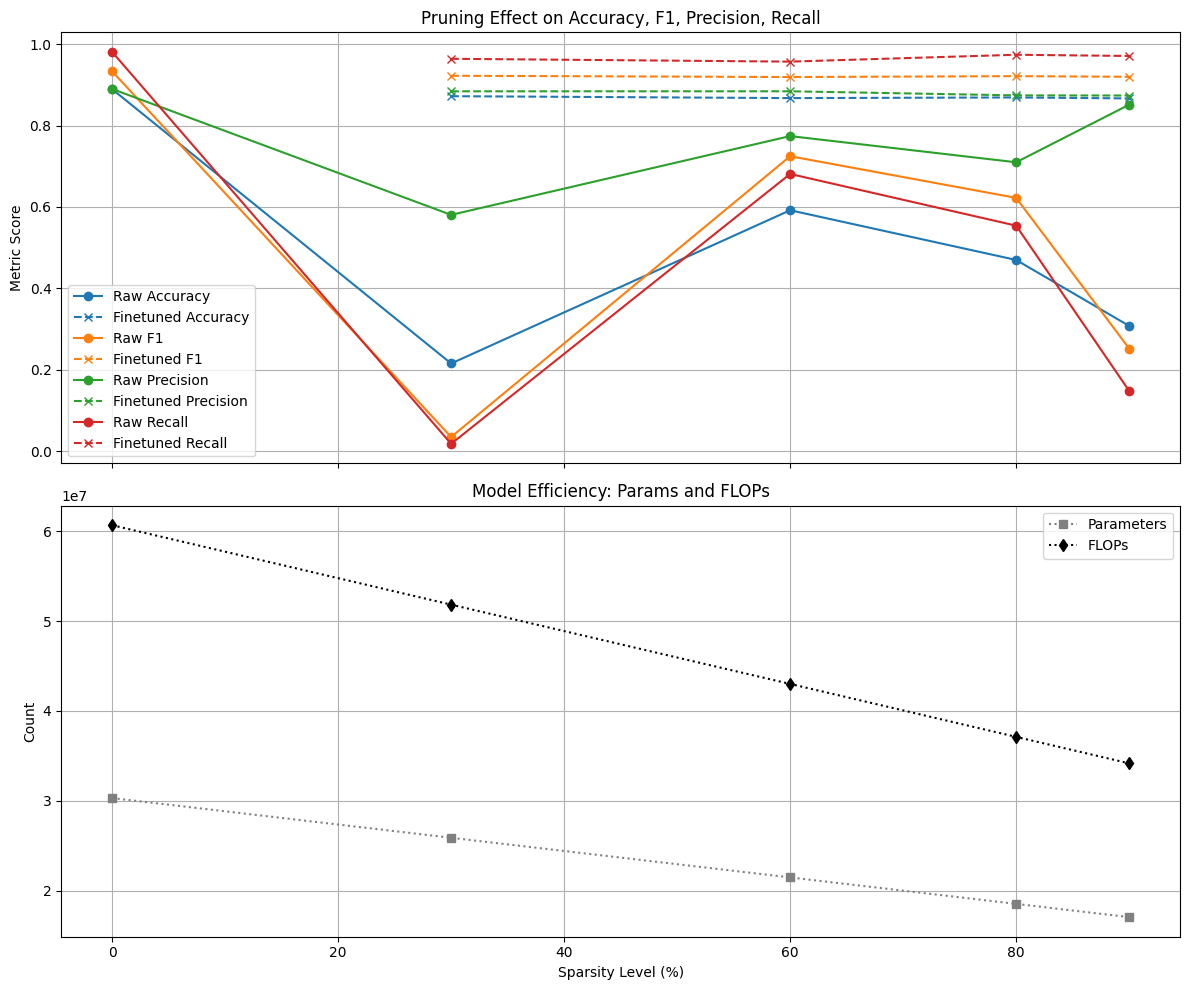

In [15]:
plot_pruning_metrics_separate_flops(model_dir)
